In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import numpy as np
from nltk.corpus import stopwords
import string
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedKFold, cross_validate
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import wilcoxon
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import ttest_rel
from scipy.stats import shapiro
from joblib import dump, load

In [3]:
#classes
class Tokenizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [word_tokenize(doc.lower()) for doc in X]


class JoinTokens(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return [' '.join(tokens) for tokens in X]


class StopwordRemover(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words=None):
        self.stop_words = stop_words or set()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X è una lista di liste di token
        return [
            [token for token in tokens if token.isalpha() and token not in self.stop_words]
            for tokens in X
        ]

class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=5, min_count=2, sg=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.sg = sg
        self.model = None

    def fit(self, X, y=None):
        self.model = Word2Vec(
            sentences=X,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4,
            sg=self.sg
        )
        return self

    def transform(self, X):
        transformed = []
        for doc in X:
            vectors = [self.model.wv[word] for word in doc if word in self.model.wv]
            if vectors:
                doc_vector = np.mean(vectors, axis=0)
            else:
                doc_vector = np.zeros(self.vector_size)
            transformed.append(doc_vector)
        return np.array(transformed)

In [78]:
#utility functions
def cross_validate_and_evaluate(clf, X, y, cv=10):
    results = cross_validate(
        clf, X, y,
        cv=KFold(cv,shuffle=True,random_state=42),
        scoring='accuracy',
        return_train_score=False
    )
    accuracies = results['test_score']
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"Accuracy fold-by-fold: {accuracies}")
    print(f"Media accuracy: {mean_acc:.4f}")
    print(f"Deviazione standard: {std_acc:.4f}")
    
    return accuracies, mean_acc, std_acc


def cross_validate_and_evaluate_nested(pipeline, X, y, param_grid):
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)
    clf = GridSearchCV(pipeline, param_grid=param_grid, cv=inner_cv) 
    results = cross_validate(
        clf, X, y,
        cv=outer_cv,
        scoring='accuracy',
        return_estimator=True
    )
    accuracies = results['test_score']
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"Accuracy fold-by-fold: {accuracies}")
    print(f"Media accuracy: {mean_acc:.4f}")
    print(f"Deviazione standard: {std_acc:.4f}")

    best_fold_idx = np.argmax(accuracies)
    best_estimator = results['estimator'][best_fold_idx]
    best_params = best_estimator.best_params_

    print(best_params)
    
    return best_params


def repeated_cv(clf, X, y, n_splits=10, n_repeats=3):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

    scores = cross_validate(
        clf, X, y,
        cv=rkf,
        scoring='accuracy',
        return_train_score=False
    )
    
    accuracies = scores['test_score']
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    return accuracies




def gaussian(vett1, vett2):
    
    residui = vett1 - vett2

    stat, p = shapiro(residui)

    if p > 0.05:
        return "gaussian"
    else:
        return "Not gaussian"



def wilcoxon_test(vett1,vett2):
    stat, p = wilcoxon(vett1, vett2)

    print(f"Wilcoxon Signed-Rank Test")
    print(f"Statistic: {stat:.4f}")
    print(f"P-value:   {p:.4f}")

    if p < 0.05:
        print("Different")
    else:
        print("Equal")


def t_test_paired(vett1, vett2):
    stat, p = ttest_rel(vett1, vett2)

    if p < 0.05:
        return "Different"
    else:
        return "Equal"


def build_matrix_test(vectors,vector_names):
    matrix = []

    for i in range(len(vectors)):
        row = []
        for j in range(len(vectors)):
            if i > j:
                result = t_test_paired(vectors[i], vectors[j])
                row.append(result)
            else:
                row.append("")  # triangolare superiore vuota
        matrix.append(row)

    # Crea DataFrame
    new_matrix = pd.DataFrame(matrix, index=vector_names, columns=vector_names)

    print(new_matrix)


def build_matrix_gaus(vectors,vector_names):
    matrix = []

    for i in range(len(vectors)):
        row = []
        for j in range(len(vectors)):
            if i > j:
                result = gaussian(vectors[i], vectors[j])
                row.append(result)
            else:
                row.append("")  # triangolare superiore vuota
        matrix.append(row)

    # Crea DataFrame
    new_matrix = pd.DataFrame(matrix, index=vector_names, columns=vector_names)

    print(new_matrix)

In [5]:
#hyperparams on which to perform grid_search
param_grid_logreg = {
    'clf__C': [0.01, 0.1, 1, 10]
}
param_grid_nb = {
    'clf__alpha': [0.1, 0.5, 1.0]
}
param_grid_dt = {
    'clf__max_depth': [10, 20, 30]
}
param_grid_svc = {
    'clf__C': [0.1, 1, 10,100]
}
param_grid_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [10, 20]
}
param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 6, 10]
}
param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7]
}

In [6]:
#stopwords
stopwords_eng = set(stopwords.words('english'))
punctuation_symbols = set(string.punctuation)
custom_symbols = {'%', '+', '-', '*', '/', '=', '<', '>', '==', '!=', '&', '|', '^', '~'}
all_stopwords = stopwords_eng.union(punctuation_symbols).union(custom_symbols)
all_stopwords.update([str(d) for d in range(2025)])

In [9]:
#pipelines

#TF-IDF
# Logistic Regression
pipeline_logreg = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Naive Bayes
pipeline_nb = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', MultinomialNB())
])

# Decision Tree
pipeline_dt = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', DecisionTreeClassifier())
])

# Support Vector Classifier
pipeline_svc = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', SVC(kernel = 'linear', probability=True))
])

# Random Forest
pipeline_rf = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', RandomForestClassifier())
])

# XGBoost
pipeline_xgb = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

#Word2Vec

text_clf_logreg = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', LogisticRegression(max_iter=1000))
])

text_clf_dt = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', DecisionTreeClassifier())
])

text_clf_svc = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', SVC(kernel='linear',probability=True))  
])

text_clf_rf = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', RandomForestClassifier(n_estimators=100))
])

text_clf_xgb = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])


Missing values:
title       0
abstract    0
label       0
dtype: int64
Colonne del dataset:
Index(['title', 'abstract', 'label'], dtype='object')


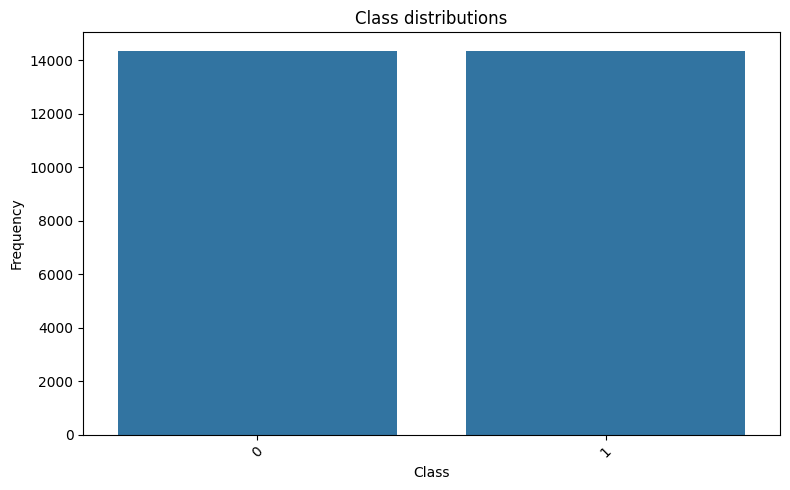

unique titles: 14331
Unique titles per class:
label
0    14331
1    14331
Name: title, dtype: int64


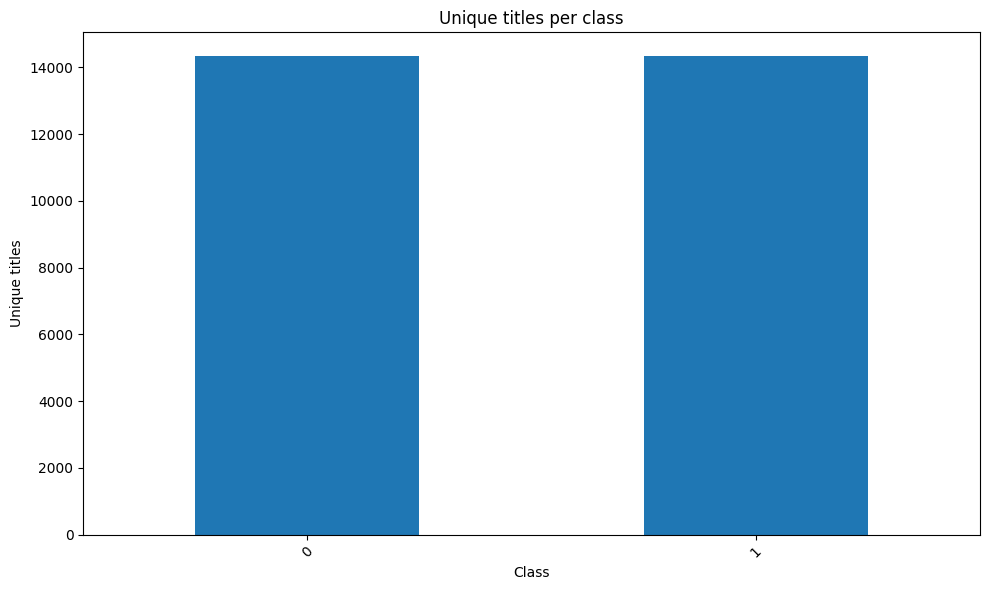

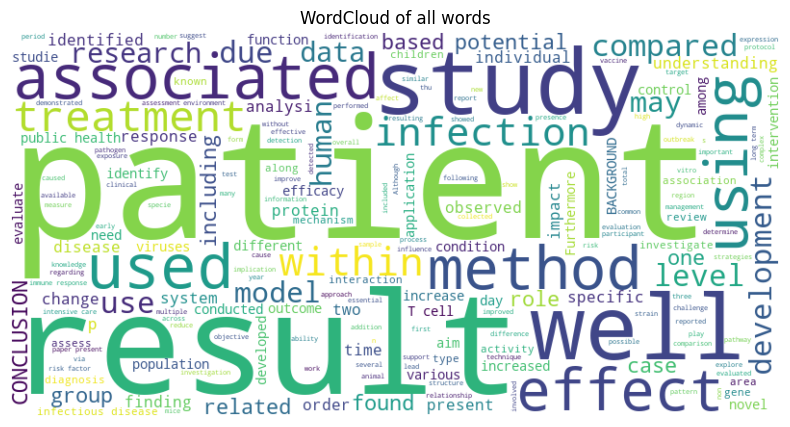

In [4]:
# Load dataset
dataset = pd.read_csv("C:/Users/franc/Downloads/ai-ga-dataset.csv")

print("Missing values:")
print(dataset.isnull().sum())

# Features of dataset
print("Colonne del dataset:")
print(dataset.columns)

# Class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='label', order=dataset['label'].value_counts().index)
plt.title("Class distributions")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#unique titles
num_titoli_unici = dataset['title'].nunique()
print(f"unique titles: {num_titoli_unici}")

# Unique titles per class
titoli_per_classe = dataset.groupby('label')['title'].nunique()
print("Unique titles per class:")
print(titoli_per_classe)

plt.figure(figsize=(10, 6))
titoli_per_classe.sort_values(ascending=False).plot(kind='bar')
plt.title("Unique titles per class")
plt.xlabel("Class")
plt.ylabel("Unique titles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



def genera_wordcloud(testo, titolo):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(testo)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(titolo)
    plt.show()

testo_titoli = " ".join(dataset['title'].dropna().astype(str))
testo_abstract = " ".join(dataset['abstract'].dropna().astype(str))

# WordCloud of all words
testo_totale = testo_titoli + " " + testo_abstract
genera_wordcloud(testo_totale, "WordCloud of all words")


In [3]:
#data-preprocessing
df = pd.read_csv("C:/Users/franc/Downloads/ai-ga-dataset.csv")



selected_indices = []
for title, group in df.groupby('title'):
    labels_present = group['label'].unique()
    if set(labels_present) == {0, 1}:
        label_to_choose = random.choice([0, 1])
        chosen_row = group[group['label'] == label_to_choose].sample(1, random_state=42)
    else:
        chosen_row = group.sample(1, random_state=42)
    selected_indices.append(chosen_row.index[0])

df_selected = df.loc[selected_indices].reset_index(drop=True)
df_selected = df_selected.drop_duplicates(subset='abstract', keep='first')
df_selected.to_csv("C:/Users/franc/Downloads/ai-ga-dataset-final.csv", index=False)


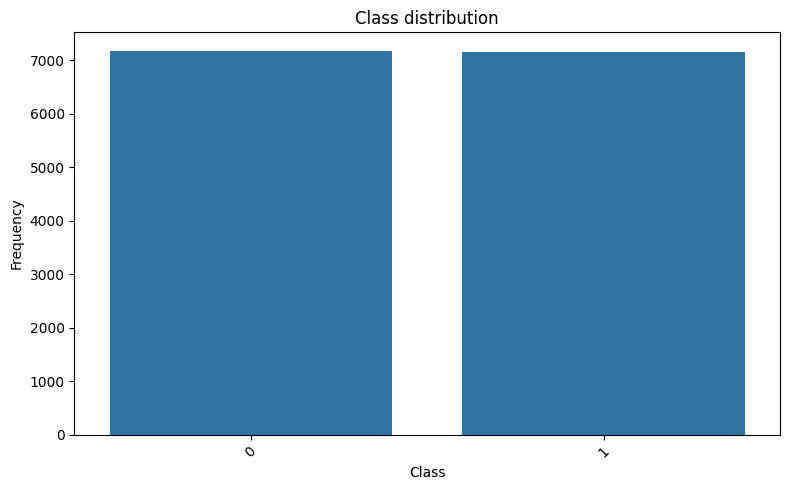


Class distribution:
label
0    7164
1    7163
Name: count, dtype: int64


In [4]:
dataset = pd.read_csv("C:/Users/franc/Downloads/ai-ga-dataset-final.csv")

plt.figure(figsize=(8, 5))
sns.countplot(data=dataset, x='label', order=dataset['label'].value_counts().index)
plt.title("Class distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


print("\nClass distribution:")
print(dataset['label'].value_counts())

In [11]:
#splitting
df_save = pd.read_csv("C:/Users/franc/Downloads/ai-ga-dataset-final.csv")
X = df_save['abstract'].tolist()
y = df_save['label'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
#models evaluation

#tf-idf
best_params_logreg = cross_validate_and_evaluate_nested(pipeline_logreg, X_train, y_train, param_grid_logreg)
best_params_nb = cross_validate_and_evaluate_nested(pipeline_nb, X_train, y_train, param_grid_nb)
best_params_dt = cross_validate_and_evaluate_nested(pipeline_dt, X_train, y_train, param_grid_dt)
best_params_svc = cross_validate_and_evaluate_nested(pipeline_svc, X_train, y_train, param_grid_svc)
best_params_rf = cross_validate_and_evaluate_nested(pipeline_rf, X_train, y_train, param_grid_rf)
best_params_xgb = cross_validate_and_evaluate_nested(pipeline_xgb, X_train, y_train, param_grid_xgb)

#word2Vec
best_params_logreg_w2v = cross_validate_and_evaluate_nested(text_clf_logreg, X_train, y_train, param_grid_logreg)
best_params_dt_w2v = cross_validate_and_evaluate_nested(text_clf_dt, X_train, y_train,param_grid_dt )
best_params_svc_w2v = cross_validate_and_evaluate_nested(text_clf_svc, X_train, y_train, param_grid_svc)
best_params_rf_w2v = cross_validate_and_evaluate_nested(text_clf_rf, X_train, y_train, param_grid_rf)
best_params_xgb_w2v = cross_validate_and_evaluate_nested(text_clf_xgb, X_train, y_train, param_grid_xgb)

Accuracy fold-by-fold: [0.95466434 0.95466434 0.95989538 0.96338274 0.95636998 0.95549738
 0.96335079 0.94589878 0.96858639 0.95724258]
Media accuracy: 0.9580
Deviazione standard: 0.0059
{'clf__C': 1}
Accuracy fold-by-fold: [0.88666085 0.85265911 0.87183958 0.87619878 0.86823735 0.86910995
 0.88394415 0.87870855 0.89179756 0.86038394]
Media accuracy: 0.8740
Deviazione standard: 0.0114
{'clf__alpha': 0.1}
Accuracy fold-by-fold: [0.87968614 0.88404534 0.88404534 0.90671316 0.87958115 0.89092496
 0.88917976 0.88045375 0.89703316 0.88394415]
Media accuracy: 0.8876
Deviazione standard: 0.0083
{'clf__max_depth': 10}
Accuracy fold-by-fold: [0.95640802 0.95640802 0.9625109  0.96163906 0.96335079 0.95375218
 0.96596859 0.94851658 0.97033159 0.96073298]
Media accuracy: 0.9600
Deviazione standard: 0.0060
{'clf__C': 1}
Accuracy fold-by-fold: [0.9537925  0.95030514 0.93374019 0.95466434 0.94415358 0.95113438
 0.95811518 0.94589878 0.96247818 0.94851658]
Media accuracy: 0.9503
Deviazione standard: 0

In [81]:
#best configurations founded alongside hyperparams
pipeline_logreg = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', LogisticRegression(C=1,max_iter=1000))
])

pipeline_svc = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', SVC(C=1,kernel = 'linear', probability=True))
])

pipeline_xgb = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('join_tokens', JoinTokens()),
    ('tfidf', TfidfVectorizer(max_features=300)),
    ('clf', XGBClassifier(max_depth=3,n_estimators=200,use_label_encoder=False, eval_metric='logloss'))
])

text_clf_logreg = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', LogisticRegression(C=10,max_iter=1000))
])

text_clf_svc = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', SVC(C=100,kernel='linear',probability=True))  
])

text_clf_xgb = Pipeline([
    ('tokenize', Tokenizer()),
    ('remove_stopwords', StopwordRemover(stop_words=all_stopwords)),
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('clf', XGBClassifier(max_depth=3,n_estimators=200,use_label_encoder=False, eval_metric='logloss'))
])

In [13]:
#logistic regression
vett1logreg = repeated_cv(pipeline_logreg, X_train, y_train)
vett2logreg = repeated_cv(text_clf_logreg, X_train, y_train)
#svc
vett1svc = repeated_cv(pipeline_svc, X_train, y_train)
vett2svc = repeated_cv(text_clf_svc, X_train, y_train)
#xgboost
vett1xgb = repeated_cv(pipeline_xgb, X_train, y_train)
vett2xgb = repeated_cv(text_clf_xgb, X_train, y_train)

In [79]:

vectors = [
    vett1logreg, vett2logreg,
    vett1svc,   vett2svc,
    vett1xgb,   vett2xgb
]

vector_names = [
    "vett1logreg", "vett2logreg",
    "vett1svc",    "vett2svc",
    "vett1xgb",    "vett2xgb"
]

build_matrix_gaus(vectors,vector_names)
build_matrix_test(vectors,vector_names)


            vett1logreg vett2logreg  vett1svc  vett2svc  vett1xgb vett2xgb
vett1logreg                                                               
vett2logreg    gaussian                                                   
vett1svc       gaussian    gaussian                                       
vett2svc       gaussian    gaussian  gaussian                             
vett1xgb       gaussian    gaussian  gaussian  gaussian                   
vett2xgb       gaussian    gaussian  gaussian  gaussian  gaussian         
            vett1logreg vett2logreg   vett1svc   vett2svc   vett1xgb vett2xgb
vett1logreg                                                                  
vett2logreg   Different                                                      
vett1svc      Different   Different                                          
vett2svc          Equal   Different      Equal                               
vett1xgb      Different   Different  Different  Different                    
vett2xg

In [82]:
#two possible combinations: considering an ensemble with all methods without tf-idf+logistic regression and
#tf-idf+svc or an ensemble with all methods without w2vec+svc
ensemble1 = VotingClassifier(
    estimators=[
        ('w2v_logreg', text_clf_logreg),
        ('w2v_svc', text_clf_svc),
        ('w2v_xgb', text_clf_xgb),
        ('tfidf_xgb', pipeline_xgb),
    ],
    voting='soft'  
)
cross_validate_and_evaluate(ensemble1,X_train,y_train,cv=10)



ensemble2 = VotingClassifier(
    estimators=[
        ('w2v_logreg', text_clf_logreg),
        ('w2v_xgb', text_clf_xgb),
        ('tfidf_logreg', pipeline_logreg),
        ('tfidf_svc', pipeline_svc),
        ('tfidf_xgb', pipeline_xgb),
    ],
    voting='soft'  
)
cross_validate_and_evaluate(ensemble2,X_train,y_train,cv=10)

Accuracy fold-by-fold: [0.97384481 0.9668701  0.98169137 0.97646033 0.96858639 0.96945899
 0.97382199 0.96684119 0.97294939 0.97294939]
Media accuracy: 0.9723
Deviazione standard: 0.0044
Accuracy fold-by-fold: [0.97907585 0.97297297 0.97994769 0.97646033 0.97120419 0.96771379
 0.97643979 0.96335079 0.98080279 0.97731239]
Media accuracy: 0.9745
Deviazione standard: 0.0054


(array([0.97907585, 0.97297297, 0.97994769, 0.97646033, 0.97120419,
        0.96771379, 0.97643979, 0.96335079, 0.98080279, 0.97731239]),
 0.974528057867021,
 0.0053795922877699085)

In [83]:
vett_ensemble1 = repeated_cv(ensemble1,X_train,y_train)
vett_ensemble2 = repeated_cv(ensemble2,X_train,y_train)

In [84]:
vectors = [
    vett_ensemble1, vett_ensemble2
]

vector_names = [
    "vett_ensemble1", "vett_ensemble2"
]

build_matrix_gaus(vectors,vector_names)
build_matrix_test(vectors,vector_names)

               vett_ensemble1 vett_ensemble2
vett_ensemble1                              
vett_ensemble2       gaussian               
               vett_ensemble1 vett_ensemble2
vett_ensemble1                              
vett_ensemble2      Different               


In [86]:
#we choose now ensemble2 because has the better accuracy score during cv
ensemble2.fit(X_train,y_train)
dump(ensemble2,'ensemble2.joblib')

['ensemble2.joblib']

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1430
           1       0.98      0.98      0.98      1437

    accuracy                           0.98      2867
   macro avg       0.98      0.98      0.98      2867
weighted avg       0.98      0.98      0.98      2867



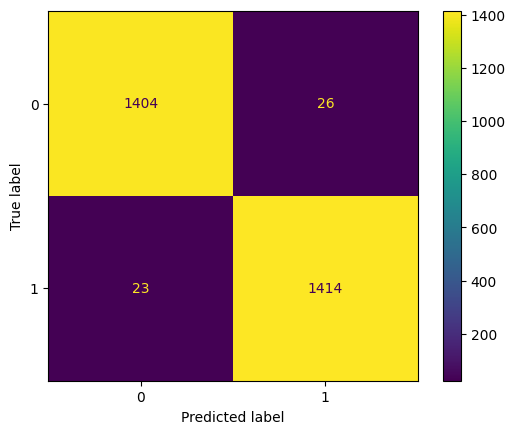

In [87]:
y_pred = ensemble2.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()